# Do early motif detectors gate late domain detectors? 

1. Do ranking for all latent-token pairs
2. Find layer wise sets as per performance check
3. In a clean forward pass:
   - Hook to ablate layer 4 set
   - Hook to record later layer activations for their sets

## Step 1: causal ranking

In [1]:
# Import necessary libraries and functions from helper modules
import sys
sys.path.append('../plm_circuits')

# Import utility functions
from helpers.utils import (
    clear_memory,
    load_esm,
    load_sae_prot,
    mask_flanks_segment,
    patching_metric,
    cleanup_cuda
)

# Import attribution functions
from attribution import (
    integrated_gradients_sae,
    topk_sae_err_pt
)

# Import hook classes
from hook_manager import SAEHookProt

# Additional imports
import json
from functools import partial
import torch
import numpy as np
import matplotlib.pyplot as plt
import collections


In IPython
Set autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
In IPython
Set autoreload


In [2]:
# Setup device and load models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load ESM-2 model
esm_transformer, batch_converter, esm2_alphabet = load_esm(33, device=device)

# Load SAEs for multiple layers
main_layers = [4, 8, 12, 16, 20, 24, 28]
saes = []
for layer in main_layers:
    sae_model = load_sae_prot(ESM_DIM=1280, SAE_DIM=4096, LAYER=layer, device=device)
    saes.append(sae_model)

layer_2_saelayer = {layer: layer_idx for layer_idx, layer in enumerate(main_layers)}

Using device: cuda


In [3]:
# Load sequence data and define protein parameters
with open('../data/full_seq_dict.json', "r") as json_file:
    seq_dict = json.load(json_file)

# Define protein-specific parameters
sse_dict = {"2B61A": [[182, 316]], "1PVGA": [[101, 202]]}
fl_dict = {"2B61A": [44, 43], "1PVGA": [65, 63]}

# Choose protein for analysis
protein = "2B61A"
seq = seq_dict[protein]
position = sse_dict[protein][0]

# Define segment boundaries
ss1_start = position[0] - 5 
ss1_end = position[0] + 5 + 1 
ss2_start = position[1] - 5 
ss2_end = position[1] + 5 + 1 

print(f"Analyzing protein: {protein}")
print(f"Sequence length: {len(seq)}")
print(f"Segment 1: {ss1_start}-{ss1_end}")
print(f"Segment 2: {ss2_start}-{ss2_end}")


Analyzing protein: 2B61A
Sequence length: 377
Segment 1: 177-188
Segment 2: 311-322


In [4]:
# Prepare full sequence and get baseline contact predictions
full_seq_L = [(1, seq)]
_, _, batch_tokens_BL = batch_converter(full_seq_L)
batch_tokens_BL = batch_tokens_BL.to(device)
batch_mask_BL = (batch_tokens_BL != esm2_alphabet.padding_idx).to(device)

with torch.no_grad():
    full_seq_contact_LL = esm_transformer.predict_contacts(batch_tokens_BL, batch_mask_BL)[0]

# Prepare clean sequence (with optimal flanks)
clean_fl = fl_dict[protein][0]
L = len(seq)
left_start = max(0, ss1_start - clean_fl)
left_end = ss1_start
right_start = ss2_end
right_end = min(L, ss2_end + clean_fl)
unmask_left_idxs = list(range(left_start, left_end))
unmask_right_idxs = list(range(right_start, right_end))

clean_seq_L = mask_flanks_segment(seq, ss1_start, ss1_end, ss2_start, ss2_end, unmask_left_idxs, unmask_right_idxs)
_, _, clean_batch_tokens_BL = batch_converter([(1, clean_seq_L)])
clean_batch_tokens_BL = clean_batch_tokens_BL.to(device)
clean_batch_mask_BL = (clean_batch_tokens_BL != esm2_alphabet.padding_idx).to(device)

with torch.no_grad():
    clean_seq_contact_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]

print(f"Clean flank size: {clean_fl}")
print(f"Clean sequence contact recovery: {patching_metric(clean_seq_contact_LL, full_seq_contact_LL, ss1_start, ss1_end, ss2_start, ss2_end):.4f}")


Clean flank size: 44
Clean sequence contact recovery: 0.5738


In [5]:
# Prepare corrupted sequence (with suboptimal flanks)
corr_fl = fl_dict[protein][1]
left_start = max(0, ss1_start - corr_fl)
left_end = ss1_start
right_start = ss2_end
right_end = min(L, ss2_end + corr_fl)
unmask_left_idxs = list(range(left_start, left_end))
unmask_right_idxs = list(range(right_start, right_end))

corr_seq_L = mask_flanks_segment(seq, ss1_start, ss1_end, ss2_start, ss2_end, unmask_left_idxs, unmask_right_idxs)
_, _, corr_batch_tokens_BL = batch_converter([(1, corr_seq_L)])
corr_batch_tokens_BL = corr_batch_tokens_BL.to(device)
corr_batch_mask_BL = (corr_batch_tokens_BL != esm2_alphabet.padding_idx).to(device)

with torch.no_grad():
    corr_seq_contact_LL = esm_transformer.predict_contacts(corr_batch_tokens_BL, corr_batch_mask_BL)[0]

print(f"Corrupted flank size: {corr_fl}")
print(f"Corrupted sequence contact recovery: {patching_metric(corr_seq_contact_LL, full_seq_contact_LL, ss1_start, ss1_end, ss2_start, ss2_end):.4f}")

# Create patching metric function
_patching_metric = partial(
    patching_metric,
    orig_contact=full_seq_contact_LL,
    ss1_start=ss1_start,
    ss1_end=ss1_end,
    ss2_start=ss2_start,
    ss2_end=ss2_end,
)


Corrupted flank size: 43
Corrupted sequence contact recovery: 0.0279


In [6]:
# Perform causal ranking for all latent-token pairs across layers
print("Starting causal ranking with integrated gradients...")

all_effects_sae_ALS = []
all_effects_err_ABLF = []

for layer_idx in main_layers:
    print(f"\nProcessing layer {layer_idx}...")
    
    sae_model = saes[layer_2_saelayer[layer_idx]]

    # Get clean cache and error
    hook = SAEHookProt(sae=sae_model, mask_BL=clean_batch_mask_BL, cache_latents=True, layer_is_lm=False, calc_error=True, use_error=True)
    handle = esm_transformer.esm.encoder.layer[layer_idx].register_forward_hook(hook)
    with torch.no_grad():
        clean_seq_sae_contact_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]
    cleanup_cuda()
    handle.remove()
    clean_cache_LS = sae_model.feature_acts
    clean_err_cache_BLF = sae_model.error_term
    clean_contact_recovery = _patching_metric(clean_seq_sae_contact_LL)

    # Get corrupted cache and error
    hook = SAEHookProt(sae=sae_model, mask_BL=corr_batch_mask_BL, cache_latents=True, layer_is_lm=False, calc_error=True, use_error=True)
    handle = esm_transformer.esm.encoder.layer[layer_idx].register_forward_hook(hook)
    with torch.no_grad():
        corr_seq_sae_contact_LL = esm_transformer.predict_contacts(corr_batch_tokens_BL, corr_batch_mask_BL)[0]
    cleanup_cuda()
    handle.remove()
    corr_cache_LS = sae_model.feature_acts
    corr_err_cache_BLF = sae_model.error_term
    corr_contact_recovery = _patching_metric(corr_seq_sae_contact_LL)
    
    print(f"Layer {layer_idx}: Clean contact recovery: {clean_contact_recovery:.4f}, Corr contact recovery: {corr_contact_recovery:.4f}")

    # Run integrated gradients
    effect_sae_LS, effect_err_BLF = integrated_gradients_sae(
        esm_transformer,
        sae_model,
        _patching_metric,
        clean_cache_LS.to(device),
        corr_cache_LS.to(device),
        clean_err_cache_BLF.to(device),
        corr_err_cache_BLF.to(device),
        batch_tokens=clean_batch_tokens_BL,
        batch_mask=clean_batch_mask_BL,
        hook_layer=layer_idx,
    )

    all_effects_sae_ALS.append(effect_sae_LS)
    all_effects_err_ABLF.append(effect_err_BLF)

# Stack all effects
all_effects_sae_ALS = torch.stack(all_effects_sae_ALS)
all_effects_err_ABLF = torch.stack(all_effects_err_ABLF)

print(f"\nCausal ranking complete!")
print(f"SAE effects shape: {all_effects_sae_ALS.shape}")
print(f"Error effects shape: {all_effects_err_ABLF.shape}")


Starting causal ranking with integrated gradients...

Processing layer 4...
Layer 4: Clean contact recovery: 0.5738, Corr contact recovery: 0.0279
ratio: 0.0, score: 0.5738044381141663
ratio: 0.1, score: 0.6011377573013306
ratio: 0.2, score: 0.48159825801849365
ratio: 0.30000000000000004, score: 0.4985215365886688
ratio: 0.4, score: 0.33681926131248474
ratio: 0.5, score: 0.2868569493293762
ratio: 0.6000000000000001, score: 0.24697960913181305
ratio: 0.7000000000000001, score: 0.12411198765039444
ratio: 0.8, score: 0.10039413720369339
ratio: 0.9, score: 0.03326641395688057

Processing layer 8...
Layer 8: Clean contact recovery: 0.5738, Corr contact recovery: 0.0279
ratio: 0.0, score: 0.5738064050674438
ratio: 0.1, score: 0.5731545686721802
ratio: 0.2, score: 0.4974464178085327
ratio: 0.30000000000000004, score: 0.4819493293762207
ratio: 0.4, score: 0.456018328666687
ratio: 0.5, score: 0.3371953070163727
ratio: 0.6000000000000001, score: 0.24517767131328583
ratio: 0.7000000000000001, sco

In [ ]:
# Extract top-k most influential components
k_top = 100  # Number of top components to extract
print(f"Extracting top-{k_top} most influential components...")

# Get top-k components using different ranking strategies
topk_abs = topk_sae_err_pt(all_effects_sae_ALS, all_effects_err_ABLF, k=k_top, mode="abs")
topk_pos = topk_sae_err_pt(all_effects_sae_ALS, all_effects_err_ABLF, k=k_top, mode="pos")
topk_neg = topk_sae_err_pt(all_effects_sae_ALS, all_effects_err_ABLF, k=k_top, mode="neg")

print("\nTop 10 components by absolute effect:")
for i, entry in enumerate(topk_abs[:10]):
    layer = main_layers[entry["layer_idx"]]
    print(f"{i+1}. Layer {layer}, Token {entry['token_idx']}, {entry['type']}: {entry['value']:.6f}")

print("\nTop 10 components by positive effect:")
for i, entry in enumerate(topk_pos[:10]):
    layer = main_layers[entry["layer_idx"]]
    print(f"{i+1}. Layer {layer}, Token {entry['token_idx']}, {entry['type']}: {entry['value']:.6f}")

print("\nTop 10 components by negative effect:")
for i, entry in enumerate(topk_neg[:10]):
    layer = main_layers[entry["layer_idx"]]
    print(f"{i+1}. Layer {layer}, Token {entry['token_idx']}, {entry['type']}: {entry['value']:.6f}")

# Analyze distribution by layer
print("\n=== Component distribution by layer ===")
sae_per_layer = collections.Counter()
err_per_layer = collections.Counter()

for entry in topk_neg:  # Using negative effects as they're typically most informative
    layer_idx = entry["layer_idx"]
    if entry["type"] == "SAE":
        sae_per_layer[layer_idx] += 1
    else:
        err_per_layer[layer_idx] += 1

print("Layer\tSAE\tERR\tTotal")
for layer_idx in range(len(main_layers)):
    layer_num = main_layers[layer_idx]
    sae_count = sae_per_layer[layer_idx]
    err_count = err_per_layer[layer_idx]
    total = sae_count + err_count
    print(f"{layer_num}\t{sae_count}\t{err_count}\t{total}")

print(f"\nCausal ranking results saved in variables:")
print(f"- all_effects_sae_ALS: SAE attribution effects (shape: {all_effects_sae_ALS.shape})")
print(f"- all_effects_err_ABLF: Error attribution effects (shape: {all_effects_err_ABLF.shape})")
print(f"- topk_abs, topk_pos, topk_neg: Top-{k_top} components by different strategies")

In [26]:
# First, we need to create layer-wise caches for the performance analysis
print("Creating layer-wise caches for performance analysis...")

clean_layer_caches = {}
corr_layer_caches = {}
clean_layer_errors = {}
corr_layer_errors = {}

for layer_idx in main_layers:
    sae_model = saes[layer_2_saelayer[layer_idx]]
    
    # Clean caches
    hook = SAEHookProt(sae=sae_model, mask_BL=clean_batch_mask_BL, cache_latents=True, 
                       layer_is_lm=False, calc_error=True, use_error=True)
    handle = esm_transformer.esm.encoder.layer[layer_idx].register_forward_hook(hook)
    with torch.no_grad():
        clean_seq_sae_contact_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]
    cleanup_cuda()
    handle.remove()
    print(f"Layer {layer_idx}, clean score: {_patching_metric(clean_seq_sae_contact_LL):.4f}")
    clean_layer_caches[layer_idx] = sae_model.feature_acts
    clean_layer_errors[layer_idx] = sae_model.error_term
    # print shapes
    print(clean_layer_caches[layer_idx].shape, clean_layer_errors[layer_idx].shape)

    # Corrupted caches
    hook = SAEHookProt(sae=sae_model, mask_BL=corr_batch_mask_BL, cache_latents=True, 
                       layer_is_lm=False, calc_error=True, use_error=True)
    handle = esm_transformer.esm.encoder.layer[layer_idx].register_forward_hook(hook)
    with torch.no_grad():
        corr_seq_sae_contact_LL = esm_transformer.predict_contacts(corr_batch_tokens_BL, corr_batch_mask_BL)[0]
    cleanup_cuda()
    handle.remove()
    print(f"Layer {layer_idx}, corr score: {_patching_metric(corr_seq_sae_contact_LL):.4f}")
    corr_layer_caches[layer_idx] = sae_model.feature_acts
    corr_layer_errors[layer_idx] = sae_model.error_term

print("Layer-wise caches created successfully!")


Creating layer-wise caches for performance analysis...
Layer 4, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 4, corr score: 0.0279
Layer 8, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 8, corr score: 0.0279
Layer 12, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 12, corr score: 0.0279
Layer 16, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 16, corr score: 0.0279
Layer 20, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 20, corr score: 0.0279
Layer 24, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 24, corr score: 0.0279
Layer 28, clean score: 0.5738
torch.Size([379, 4096]) torch.Size([1, 379, 1280])
Layer 28, corr score: 0.0279
Layer-wise caches created successfully!


4 0
L=379, S=4096
Sample flat_top_idx: tensor([ 751528,  755624,  748439,  757341,  743336,  755988,  757722,  751101,
        1294298, 1291516])
Calculated tok_idx: tensor([183, 184, 182, 184, 181, 184, 184, 183, 315, 315])
Calculated lat_idx: tensor([1960, 1960, 2967, 3677, 1960, 2324, 4058, 1533, 4058, 1276])
S value used in calculation: 4096
final_effect_sae_LS shape: torch.Size([379, 4096])
corr_sae_cache_LS shape: torch.Size([379, 4096])
Do shapes match? True
clean_batch_mask_BL shape: torch.Size([1, 379])
clean_batch_mask_BL sum (num valid tokens): 379
corr_sae_cache_LS shape: torch.Size([379, 4096])
  keep   0  →  recovery 0.0272
clean_batch_mask_BL shape: torch.Size([1, 379])
clean_batch_mask_BL sum (num valid tokens): 379
corr_sae_cache_LS shape: torch.Size([379, 4096])
  keep 100  →  recovery 0.0272
clean_batch_mask_BL shape: torch.Size([1, 379])
clean_batch_mask_BL sum (num valid tokens): 379
corr_sae_cache_LS shape: torch.Size([379, 4096])
  keep 200  →  recovery 0.0272
cl

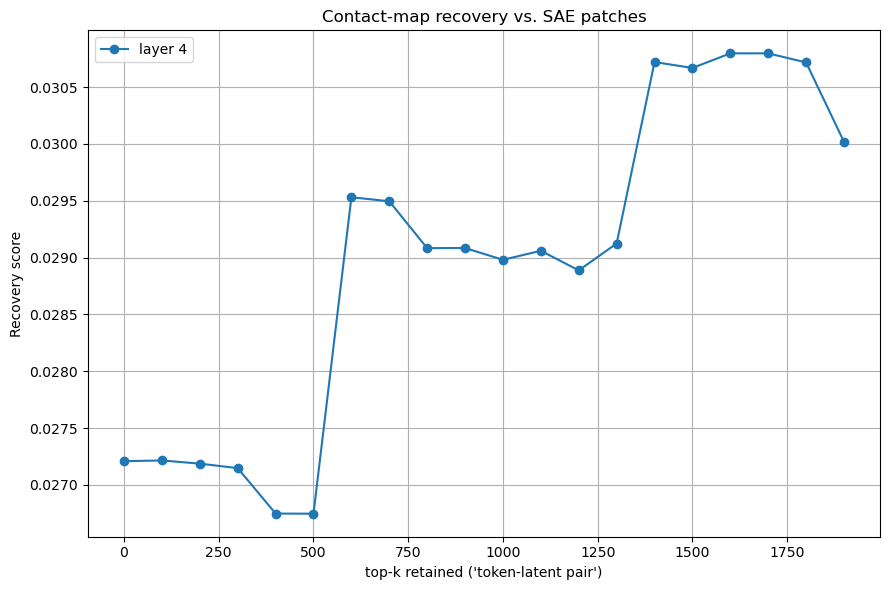

In [32]:
k_grid=list(range(0, 2000, 100))
layer_idx = 4
sae_model = saes[layer_2_saelayer[layer_idx]]
final_effect_sae_LS = all_effects_sae_ALS[layer_idx]
final_effect_err_BLF = all_effects_err_ABLF[layer_idx]
corr_sae_cache_LS = corr_layer_caches[layer_idx]
corr_err_cache_BLF = corr_layer_errors[layer_idx]
clean_err_cache_BLF = clean_layer_errors[layer_idx]
print(layer_idx, layer_2_saelayer[layer_idx])
L, S = final_effect_sae_LS.shape
print(f"L={L}, S={S}")
flat_neg = (-final_effect_sae_LS).view(-1)
_, flat_top_idx = torch.topk(flat_neg, max(k_grid))
tok_idx, lat_idx = flat_top_idx // S, flat_top_idx % S

# ADD THIS DEBUG LINE:
print(f"Sample flat_top_idx: {flat_top_idx[:10]}")
print(f"Calculated tok_idx: {tok_idx[:10]}")  
print(f"Calculated lat_idx: {lat_idx[:10]}")
print(f"S value used in calculation: {S}")
ranked_pairs      = list(zip(tok_idx.tolist(), lat_idx.tolist()))
layer_scores = []
sae_model.mean_error = clean_err_cache_BLF

print(f"final_effect_sae_LS shape: {final_effect_sae_LS.shape}")
print(f"corr_sae_cache_LS shape: {corr_sae_cache_LS.shape}")
print(f"Do shapes match? {final_effect_sae_LS.shape == corr_sae_cache_LS.shape}")

# For k=100, check what positions are being kept

for k in k_grid:
    patch_mask_flat = torch.ones_like(corr_sae_cache_LS, dtype=torch.bool)
    # if k > 0:
    #     toks, lats = zip(*ranked_pairs[:k])
    #     patch_mask_flat[toks, lats] = False  # keep these
    # if k == 100:
    #     toks, lats = zip(*ranked_pairs[:k])
    #     print(f"Sample token indices: {toks[:10]}")
    #     print(f"Sample latent indices: {lats[:10]}")
    #     print(f"Max token index: {max(toks)}, Max latent index: {max(lats)}")
    #     print(f"Total positions kept clean: {(patch_mask_flat == False).sum()}")
    #     print(f"Total positions patched: {(patch_mask_flat == True).sum()}")
    print(f"clean_batch_mask_BL shape: {clean_batch_mask_BL.shape}")
    print(f"clean_batch_mask_BL sum (num valid tokens): {clean_batch_mask_BL.sum()}")
    print(f"corr_sae_cache_LS shape: {corr_sae_cache_LS.shape}")
    # Instead of filtering, just put both on the same device:
    patch_mask_flat = torch.ones_like(corr_sae_cache_LS, dtype=torch.bool, device=device)
    if k > 0:
        toks, lats = zip(*ranked_pairs[:k])
        patch_mask_flat[toks, lats] = False

    hook = SAEHookProt(
        sae=sae_model, mask_BL=clean_batch_mask_BL,
        patch_mask_BLS=patch_mask_flat,  # Already on device
        patch_value=corr_sae_cache_LS.to(device),
        layer_is_lm=False, use_mean_error=True,
    )

    # ---- run model with this hook ----
    reg = esm_transformer.esm.encoder.layer[layer_idx] \
                                .register_forward_hook(hook)
    with torch.no_grad():
        pred_contact = esm_transformer.predict_contacts(
            clean_batch_tokens_BL, clean_batch_mask_BL
        )[0]
    reg.remove(); cleanup_cuda()
    score = patching_metric(
        pred_contact, full_seq_contact_LL,
        ss1_start, ss1_end, ss2_start, ss2_end
    )
    print(f"  keep {k:3d}  →  recovery {score:.4f}")
    layer_scores.append(score.cpu())

import matplotlib.pyplot as plt
plt.figure(figsize=(9, 6))

plt.plot(k_grid, layer_scores, marker="o", label=f"layer {layer_idx}")
plt.xlabel(f"top‑k retained "
            f"('token‑latent pair')")
plt.ylabel("Recovery score")
plt.title("Contact‑map recovery vs. SAE patches")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

In [17]:
# Define proper layer-wise top-k function (fixes the global top-k issue)
def topk_sae_err_single_layer(
    effects_sae_ALS: torch.Tensor,   # (A, L, S)
    effects_err_ALF: torch.Tensor,   # (A, L, F)
    target_layer_idx: int,           # Which layer to get top-k from
    k: int = 10,
    mode: str = "abs",              # "abs" | "pos" | "neg"
    include_error: bool = True,      # Whether to include error components in ranking
):
    """Get top-k components from a specific layer only."""
    
    if mode not in {"abs", "pos", "neg"}:
        raise ValueError(f"mode must be 'abs', 'pos' or 'neg' – got {mode!r}")

    # Extract effects for target layer only
    sae_effects_LS = effects_sae_ALS[target_layer_idx]  # (L, S)
    err_effects_LF = effects_err_ALF[target_layer_idx]  # (L, F)
    
    L, S = sae_effects_LS.shape
    
    # Flatten effects from this layer only
    sae_flat = sae_effects_LS.reshape(-1)                  # L·S
    
    if include_error:
        # Include both SAE and error components
        err_flat = err_effects_LF.sum(dim=-1).reshape(-1)      # L (collapse F)
        combined = torch.cat([sae_flat, err_flat], dim=0)      # (L·S + L)
    else:
        # Only SAE components (when fixed_error=True, error components aren't patched)
        combined = sae_flat                                    # L·S only

    # Choose ranking criterion
    if mode == "abs":
        ranking_tensor = combined.abs()
        largest_flag = True
    elif mode == "pos":
        ranking_tensor = combined
        largest_flag = True
    else:  # mode == "neg"
        ranking_tensor = combined
        largest_flag = False

    # Get top-k from this layer
    top_rank_vals, top_idx = torch.topk(ranking_tensor, min(k, len(combined)), largest=largest_flag, sorted=True)
    top_vals = combined[top_idx]

    # Decode indices back to coordinates
    sae_len = sae_flat.numel()
    out = []
    for val, idx in zip(top_vals.tolist(), top_idx.tolist()):
        if not include_error or idx < sae_len:  # SAE element
            if include_error:
                token = idx // S
                latent = idx % S
            else:
                token = idx // S
                latent = idx % S
            out.append({
                "type": "SAE",
                "value": val,
                "layer_idx": target_layer_idx,
                "token_idx": token,
                "latent_idx": latent,
            })
        else:  # ERR element (only when include_error=True)
            token = idx - sae_len
            out.append({
                "type": "ERR",
                "value": val,
                "layer_idx": target_layer_idx,
                "token_idx": token,
            })
    return out

from typing import List, Dict
def topk_performance_single_layer(
    esm_transformer, 
    saes, 
    all_effects_sae_ALS, 
    all_effects_err_ABLF, 
    k: int,
    mode: str,
    target_layer_idx: int,  # Which layer to focus on (index in main_layers)
    corr_layer_caches, 
    corr_layer_errors,
    clean_layer_errors, 
    layer_2_saelayer, 
    saelayer_2_layer,
    device, 
    clean_batch_tokens_BL, 
    clean_batch_mask_BL, 
    _patching_metric, 
    main_layers, 
    fixed_error: bool = False
):
    """
    Patch only the top-k components from a specific layer (using proper layer-wise top-k).
    """
    # Get top-k components from the target layer only 
    # If fixed_error=True, exclude error components since they won't be patched
    topk_circuit = topk_sae_err_single_layer(
        all_effects_sae_ALS, all_effects_err_ABLF, 
        target_layer_idx=target_layer_idx, k=k, mode=mode,
        include_error=not fixed_error  # Exclude error components when fixed_error=True
    )
    
    if not topk_circuit:
        # No components from this layer, return clean performance
        with torch.no_grad():
            preds_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]
        return _patching_metric(preds_LL), topk_circuit
    
    # Get the actual layer number
    target_layer_num = main_layers[target_layer_idx]
    
    # Create mask only for the target layer
    sae_model = saes[layer_2_saelayer[target_layer_num]]
    L, S = sae_model.feature_acts.shape if hasattr(sae_model, 'feature_acts') else (clean_batch_mask_BL.shape[1], 4096)
    F = corr_layer_errors[target_layer_num].shape[-1]
    
    sae_m = torch.ones((L, S), dtype=torch.bool, device=device)  # FALSE → keep clean
    err_m = torch.ones((1, L, F), dtype=torch.bool, device=device)
    
    # Apply patches for components from target layer
    for entry in topk_circuit:
        t = entry["token_idx"]
        if entry["type"] == "SAE":
            u = entry["latent_idx"]
            sae_m[t, u] = False
        else:  # "ERR"
            err_m[0, t, :] = False
    
    # Set up the hook for the target layer only
    sae_model = saes[layer_2_saelayer[target_layer_num]]
    corr_lat_LS = corr_layer_caches[target_layer_num]
    clean_err_LF = clean_layer_errors[target_layer_num]
    corr_err_LF = corr_layer_errors[target_layer_num]
    
    # Choose which values will overwrite the clean forward
    lat_patch_val = corr_lat_LS
    if fixed_error:
        sae_model.mean_error = clean_err_LF
    else:
        sae_model.mean_error = err_m * corr_err_LF + (~err_m) * clean_err_LF

    hook = SAEHookProt(
        sae=sae_model,
        mask_BL=clean_batch_mask_BL,
        patch_mask_BLS=sae_m.to(device),
        patch_value=lat_patch_val.to(device),
        use_mean_error=True,
    )
    handle = esm_transformer.esm.encoder.layer[target_layer_num].register_forward_hook(hook)

    # Forward pass & metric
    with torch.no_grad():
        preds_LL = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]
    rec = _patching_metric(preds_LL)

    # Clean up
    handle.remove()
    cleanup_cuda()
    return rec, topk_circuit

def plot_layer_performance_sweep(
    modes: List[str],
    start_k: int,
    end_k: int,
    step_k: int,
    mode2label: Dict[str, str],
    *,
    fixed_error: bool = False,
    corr_layer_caches,
    corr_layer_errors,
    clean_layer_errors,
    esm_transformer,
    saes,
    all_effects_sae_ALS,
    all_effects_err_ABLF,
    layer_2_saelayer,
    saelayer_2_layer,
    device,
    clean_batch_tokens_BL,
    clean_batch_mask_BL,
    _patching_metric,
    main_layers,
    clean_contact_recovery: float,
    **kwargs,
):
    """
    Plot performance curves for each layer separately.
    
    Each layer gets its own curve showing how performance changes 
    as we patch more of its top-k components.
    """
    ks = list(range(start_k, end_k + 1, step_k))
    
    plt.figure(figsize=(12, 8))
    
    # Plot curve for each layer
    for layer_idx, layer_num in enumerate(main_layers):
        print(f"\nProcessing layer {layer_num}...")
        
        layer_recs = {}
        for mode in modes:
            recs = []
            for k in ks:
                rec, _ = topk_performance_single_layer(
                    esm_transformer=esm_transformer,
                    saes=saes,
                    all_effects_sae_ALS=all_effects_sae_ALS,
                    all_effects_err_ABLF=all_effects_err_ABLF,
                    k=k,
                    mode=mode,
                    target_layer_idx=layer_idx,
                    corr_layer_caches=corr_layer_caches,
                    corr_layer_errors=corr_layer_errors,
                    clean_layer_errors=clean_layer_errors,
                    layer_2_saelayer=layer_2_saelayer,
                    saelayer_2_layer=saelayer_2_layer,
                    device=device,
                    clean_batch_tokens_BL=clean_batch_tokens_BL,
                    clean_batch_mask_BL=clean_batch_mask_BL,
                    _patching_metric=_patching_metric,
                    main_layers=main_layers,
                    fixed_error=fixed_error,
                )
                recs.append(rec.item())
            layer_recs[mode] = recs
            
            # Plot this layer's curve for this mode
            linestyle = '--' if mode == 'pos' else '-' if mode == 'neg' else ':'
            plt.plot(ks, recs, marker="o", linestyle=linestyle, 
                    label=f"Layer {layer_num} ({mode2label[mode]})", 
                    linewidth=2, markersize=4)
    
    # Reference lines
    plt.axhline(clean_contact_recovery, linestyle="--", color="black", 
                alpha=0.7, label="Clean baseline")
    plt.axhline(clean_contact_recovery * 0.6, linestyle=":", color="red", 
                alpha=0.7, label="0.6× clean")

    plt.xlabel("k (top-k components patched from single layer)")
    plt.ylabel("Contact recovery")
    plt.title("Layer-wise Performance: Top-k Components from Individual Layers")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return layer_recs

Running layer-wise performance analysis for layers: [4, 8, 12, 16, 20, 24, 28]
Clean contact recovery baseline: 0.5738

Testing layer-wise top-k extraction (FIXED VERSION):

--- With Error Components (include_error=True) ---
Layer 4: 3 SAE + 7 ERR = 10 total
Layer 8: 3 SAE + 7 ERR = 10 total
Layer 12: 5 SAE + 5 ERR = 10 total
Layer 16: 2 SAE + 8 ERR = 10 total
Layer 20: 7 SAE + 3 ERR = 10 total
Layer 24: 7 SAE + 3 ERR = 10 total
Layer 28: 8 SAE + 2 ERR = 10 total

--- Without Error Components (include_error=False, for fixed_error=True) ---
Layer 4: 10 SAE + 0 ERR = 10 total (should be all SAE)
Layer 8: 10 SAE + 0 ERR = 10 total (should be all SAE)
Layer 12: 10 SAE + 0 ERR = 10 total (should be all SAE)
Layer 16: 10 SAE + 0 ERR = 10 total (should be all SAE)
Layer 20: 10 SAE + 0 ERR = 10 total (should be all SAE)
Layer 24: 10 SAE + 0 ERR = 10 total (should be all SAE)
Layer 28: 10 SAE + 0 ERR = 10 total (should be all SAE)

Running layer-wise performance sweep with proper layer-wise top

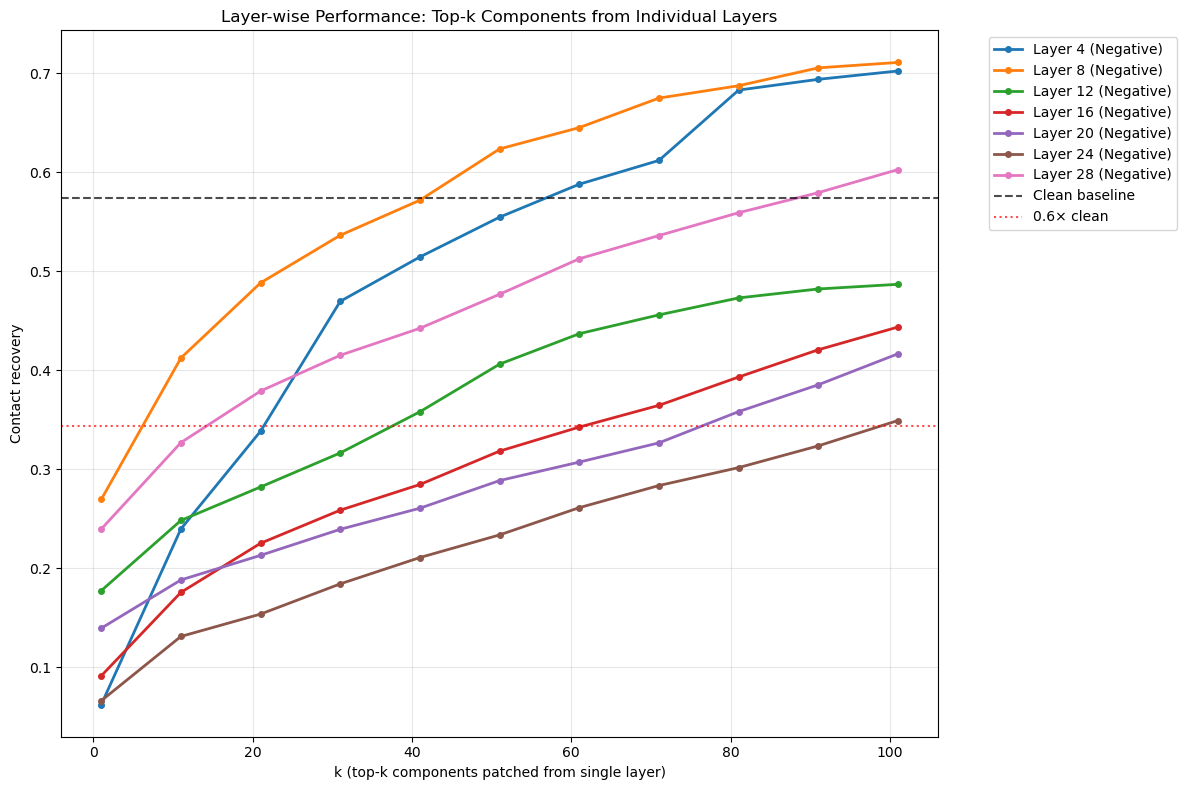

In [18]:
# Create saelayer_2_layer mapping
saelayer_2_layer = {v: k for k, v in layer_2_saelayer.items()}

# Get clean contact recovery as reference
with torch.no_grad():
    clean_baseline = esm_transformer.predict_contacts(clean_batch_tokens_BL, clean_batch_mask_BL)[0]
clean_contact_recovery = _patching_metric(clean_baseline)

print(f"Running layer-wise performance analysis for layers: {main_layers}")
print(f"Clean contact recovery baseline: {clean_contact_recovery:.4f}")

# Test the layer-wise top-k function to verify it's working correctly
print(f"\nTesting layer-wise top-k extraction (FIXED VERSION):")

# Test with error components included
print("\n--- With Error Components (include_error=True) ---")
for layer_idx, layer_num in enumerate(main_layers):
    layer_topk = topk_sae_err_single_layer(
        all_effects_sae_ALS, all_effects_err_ABLF, 
        target_layer_idx=layer_idx, k=10, mode="neg", include_error=True
    )
    sae_count = sum(1 for x in layer_topk if x['type'] == 'SAE')
    err_count = sum(1 for x in layer_topk if x['type'] == 'ERR')
    print(f"Layer {layer_num}: {sae_count} SAE + {err_count} ERR = {len(layer_topk)} total")

# Test without error components (for fixed_error=True)
print("\n--- Without Error Components (include_error=False, for fixed_error=True) ---")
for layer_idx, layer_num in enumerate(main_layers):
    layer_topk = topk_sae_err_single_layer(
        all_effects_sae_ALS, all_effects_err_ABLF, 
        target_layer_idx=layer_idx, k=10, mode="neg", include_error=False
    )
    sae_count = sum(1 for x in layer_topk if x['type'] == 'SAE')
    err_count = sum(1 for x in layer_topk if x['type'] == 'ERR')
    print(f"Layer {layer_num}: {sae_count} SAE + {err_count} ERR = {len(layer_topk)} total (should be all SAE)")

# Define mode labels
mode2label = {"abs": "Absolute", "pos": "Positive", "neg": "Negative"}

# Run the layer-wise performance sweep with the FIXED function
print(f"\nRunning layer-wise performance sweep with proper layer-wise top-k...")
layer_results = plot_layer_performance_sweep(
    modes=["neg"],  # Focus on negative effects (most informative)
    start_k=1,
    end_k=101,  # Number of top components to test per layer
    step_k=10,
    mode2label=mode2label,
    fixed_error=True,
    corr_layer_caches=corr_layer_caches,
    corr_layer_errors=corr_layer_errors,
    clean_layer_errors=clean_layer_errors,
    esm_transformer=esm_transformer,
    saes=saes,
    all_effects_sae_ALS=all_effects_sae_ALS,
    all_effects_err_ABLF=all_effects_err_ABLF,
    layer_2_saelayer=layer_2_saelayer,
    saelayer_2_layer=saelayer_2_layer,
    device=device,
    clean_batch_tokens_BL=clean_batch_tokens_BL,
    clean_batch_mask_BL=clean_batch_mask_BL,
    _patching_metric=_patching_metric,
    main_layers=main_layers,
    clean_contact_recovery=clean_contact_recovery.item(),
)


In [ ]:
# Analyze which layers have the most impactful components
print("=== Layer-wise Performance Analysis ===")

# Find the best single-layer performance at k=50
k_test = 50
best_layer_performance = {}

for layer_idx, layer_num in enumerate(main_layers):
    rec, circuit = topk_performance_single_layer(
        esm_transformer=esm_transformer,
        saes=saes,
        all_effects_sae_ALS=all_effects_sae_ALS,
        all_effects_err_ABLF=all_effects_err_ABLF,
        k=k_test,
        mode="neg",
        target_layer_idx=layer_idx,
        corr_layer_caches=corr_layer_caches,
        corr_layer_errors=corr_layer_errors,
        clean_layer_errors=clean_layer_errors,
        layer_2_saelayer=layer_2_saelayer,
        saelayer_2_layer=saelayer_2_layer,
        device=device,
        clean_batch_tokens_BL=clean_batch_tokens_BL,
        clean_batch_mask_BL=clean_batch_mask_BL,
        _patching_metric=_patching_metric,
        main_layers=main_layers,
        fixed_error=False,
    )
    best_layer_performance[layer_num] = {
        'recovery': rec.item(),
        'circuit_size': len(circuit)
    }

# Sort layers by performance impact
for layer_num, results in sorted(best_layer_performance.items(), key=lambda x: x[1]['recovery'], reverse=True):
    recovery = results['recovery']
    circuit_size = results['circuit_size']
    improvement = recovery - patching_metric(corr_seq_contact_LL, full_seq_contact_LL, ss1_start, ss1_end, ss2_start, ss2_end).item()
    print(f"Layer {layer_num:2d}: Recovery = {recovery:.4f} (+{improvement:.4f}), Circuit size = {circuit_size}")

print(f"\nCorrupted baseline: {patching_metric(corr_seq_contact_LL, full_seq_contact_LL, ss1_start, ss1_end, ss2_start, ss2_end):.4f}")
print(f"Clean baseline: {clean_contact_recovery:.4f}")

print("\n=== Key Insights ===")
print("1. Layers with highest single-layer impact are likely most critical for the task")
print("2. Early layers (4, 8) vs Late layers (24, 28) comparison will inform gating hypothesis")
print("3. Layers showing steep improvement curves contain concentrated important components")
print("\nReady for Step 2: Gating hypothesis testing with early vs late layer interactions!")


In [ ]:
# Demonstrate the difference between fixed_error=True vs False
print("=== Comparing fixed_error=True vs fixed_error=False ===")

# Example: Test single layer performance with both settings
test_layer_idx = 0  # Layer 4
test_k = 20

print(f"\nTesting Layer {main_layers[test_layer_idx]} with k={test_k}:")

# With fixed_error=False (includes error components)
rec_var_error, circuit_var_error = topk_performance_single_layer(
    esm_transformer=esm_transformer,
    saes=saes,
    all_effects_sae_ALS=all_effects_sae_ALS,
    all_effects_err_ABLF=all_effects_err_ABLF,
    k=test_k,
    mode="neg",
    target_layer_idx=test_layer_idx,
    corr_layer_caches=corr_layer_caches,
    corr_layer_errors=corr_layer_errors,
    clean_layer_errors=clean_layer_errors,
    layer_2_saelayer=layer_2_saelayer,
    saelayer_2_layer=saelayer_2_layer,
    device=device,
    clean_batch_tokens_BL=clean_batch_tokens_BL,
    clean_batch_mask_BL=clean_batch_mask_BL,
    _patching_metric=_patching_metric,
    main_layers=main_layers,
    fixed_error=False,
)

sae_count_var = sum(1 for x in circuit_var_error if x['type'] == 'SAE')
err_count_var = sum(1 for x in circuit_var_error if x['type'] == 'ERR')

print(f"fixed_error=False: Recovery={rec_var_error:.4f}, Circuit: {sae_count_var} SAE + {err_count_var} ERR")

# With fixed_error=True (excludes error components from ranking)
rec_fixed_error, circuit_fixed_error = topk_performance_single_layer(
    esm_transformer=esm_transformer,
    saes=saes,
    all_effects_sae_ALS=all_effects_sae_ALS,
    all_effects_err_ABLF=all_effects_err_ABLF,
    k=test_k,
    mode="neg",
    target_layer_idx=test_layer_idx,
    corr_layer_caches=corr_layer_caches,
    corr_layer_errors=corr_layer_errors,
    clean_layer_errors=clean_layer_errors,
    layer_2_saelayer=layer_2_saelayer,
    saelayer_2_layer=saelayer_2_layer,
    device=device,
    clean_batch_tokens_BL=clean_batch_tokens_BL,
    clean_batch_mask_BL=clean_batch_mask_BL,
    _patching_metric=_patching_metric,
    main_layers=main_layers,
    fixed_error=True,
)

sae_count_fixed = sum(1 for x in circuit_fixed_error if x['type'] == 'SAE')
err_count_fixed = sum(1 for x in circuit_fixed_error if x['type'] == 'ERR')

print(f"fixed_error=True:  Recovery={rec_fixed_error:.4f}, Circuit: {sae_count_fixed} SAE + {err_count_fixed} ERR")

print(f"\nKey insight: With fixed_error=True, we only rank/patch SAE components,")
print(f"giving a cleaner measure of SAE-only layer importance.")


In [ ]:
# Extract top-k most influential components
k_top = 100  # Number of top components to extract
print(f"Extracting top-{k_top} most influential components...")

# Get top-k components using different ranking strategies
topk_abs = topk_sae_err_pt(all_effects_sae_ALS, all_effects_err_ABLF, k=k_top, mode="abs")
topk_pos = topk_sae_err_pt(all_effects_sae_ALS, all_effects_err_ABLF, k=k_top, mode="pos")
topk_neg = topk_sae_err_pt(all_effects_sae_ALS, all_effects_err_ABLF, k=k_top, mode="neg")

print("\nTop 10 components by absolute effect:")
for i, entry in enumerate(topk_abs[:10]):
    layer = main_layers[entry["layer_idx"]]
    print(f"{i+1}. Layer {layer}, Token {entry['token_idx']}, {entry['type']}: {entry['value']:.6f}")

print("\nTop 10 components by positive effect:")
for i, entry in enumerate(topk_pos[:10]):
    layer = main_layers[entry["layer_idx"]]
    print(f"{i+1}. Layer {layer}, Token {entry['token_idx']}, {entry['type']}: {entry['value']:.6f}")

print("\nTop 10 components by negative effect:")
for i, entry in enumerate(topk_neg[:10]):
    layer = main_layers[entry["layer_idx"]]
    print(f"{i+1}. Layer {layer}, Token {entry['token_idx']}, {entry['type']}: {entry['value']:.6f}")

# Analyze distribution by layer
print("\n=== Component distribution by layer ===")
sae_per_layer = collections.Counter()
err_per_layer = collections.Counter()

for entry in topk_neg:  # Using negative effects as they're typically most informative
    layer_idx = entry["layer_idx"]
    if entry["type"] == "SAE":
        sae_per_layer[layer_idx] += 1
    else:
        err_per_layer[layer_idx] += 1

print("Layer\tSAE\tERR\tTotal")
for layer_idx in range(len(main_layers)):
    layer_num = main_layers[layer_idx]
    sae_count = sae_per_layer[layer_idx]
    err_count = err_per_layer[layer_idx]
    total = sae_count + err_count
    print(f"{layer_num}\t{sae_count}\t{err_count}\t{total}")

print(f"\nCausal ranking results saved in variables:")
print(f"- all_effects_sae_ALS: SAE attribution effects (shape: {all_effects_sae_ALS.shape})")
print(f"- all_effects_err_ABLF: Error attribution effects (shape: {all_effects_err_ABLF.shape})")
print(f"- topk_abs, topk_pos, topk_neg: Top-{k_top} components by different strategies")


In [ ]:
# Save intermediate results for next steps
import pickle

# Save the causal ranking and layer-wise performance results
results_to_save = {
    'all_effects_sae_ALS': all_effects_sae_ALS,
    'all_effects_err_ABLF': all_effects_err_ABLF,
    'topk_abs': topk_abs,
    'topk_pos': topk_pos,
    'topk_neg': topk_neg,
    'main_layers': main_layers,
    'protein': protein,
    'ss1_start': ss1_start,
    'ss1_end': ss1_end,
    'ss2_start': ss2_start,
    'ss2_end': ss2_end,
    'seq': seq,
    'clean_layer_caches': clean_layer_caches,
    'corr_layer_caches': corr_layer_caches,
    'clean_layer_errors': clean_layer_errors,
    'corr_layer_errors': corr_layer_errors,
    'best_layer_performance': best_layer_performance,
    'layer_2_saelayer': layer_2_saelayer,
    'saelayer_2_layer': saelayer_2_layer
}

# with open('causal_ranking_and_layer_analysis_results.pkl', 'wb') as f:
#     pickle.dump(results_to_save, f)

print("Step 1 (Causal Ranking) COMPLETE! ✓")
print("Step 2 (Layer-wise Performance Analysis) COMPLETE! ✓")
print("\nNext steps:")
print("1. Extract early vs late layer components based on performance analysis")
print("2. Design gating experiments (ablate early, measure late)")
print("3. Test causal gating hypothesis")
print("\nAll variables are saved in memory for the gating hypothesis experiments.")
